In [1]:
DATA_FOLDER = "./data"

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Обработка данных

In [3]:
import os
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option('display.precision', 2)

***Читаем датасет и удаляем дубликаты коих больше 67%***

In [4]:
data_path = os.path.join(DATA_FOLDER, "raw_push_stat_2022_01_13_.gz")
df = pd.read_csv(data_path, delimiter=';')
before = df.shape[0]
df.drop_duplicates(inplace=True)
after = df.shape[0]
print(before, after, f"{1 - after / before:.2%}")

6854281 2211058 67.74%


***Колонки с датами в datetime***

In [5]:
df["push_time"] = pd.to_datetime(df["push_time"])
df["push_opened_time"] = pd.to_datetime(df["push_opened_time"])
df["create_at"] = pd.to_datetime(df["create_at"])

In [6]:
df[["push_time", "push_opened_time", "create_at"]].describe()

,push_time,push_opened_time,create_at
count,2211058,2211058,2211058
unique,85757,125727,816
top,2021-12-12 02:03:30,2021-12-12 02:03:30,2021-07-14 01:35:04
freq,223,220,102482
first,2021-12-12 00:00:03,2021-12-12 00:00:03,2020-10-08 00:01:37
last,2021-12-14 23:59:31,2021-12-14 23:59:58,2021-12-14 19:23:09


***Для некоторых пользователей ("user_id") в одно и то же время ("push_time") пришло два пуша с разным контентом ("content_id"). Пользователь может открыть только один из них, а, возможно, даже не увидеть второй. Поэтому учет этих пушей в построении модели и ее оценке будет не справедливым. Эти строки необходимо удалить из датасета. Хорошо что их доля меньше одной сотой %***

In [7]:
tmp = df[["user_id", "push_time"]].value_counts()
tmp.name = "is_two_push_same_time"
tmp = tmp[tmp>1].reset_index()
tmp["is_two_push_same_time"] = True
if "is_two_push_same_time" in df.columns:
    df.drop(columns="is_two_push_same_time", inplace=True)
df = df.merge(tmp, on=["user_id", "push_time"], how="left")
df["is_two_push_same_time"].fillna(False, inplace=True)
pct = df["is_two_push_same_time"].sum() / df.shape[0]
f"{pct:.4%}"

'0.0015%'

**Удаляем наблюдения, для которых время открытия пуша ("push_opened_time") не совпадает со временем отправки пуша ("push_time") в случае, если переход по пушу не был совершен ("push_opened" == 0)***

In [8]:
df["is_wrong_push_opened_time"] = False
mask = (df["push_opened_time"] > df["push_time"]) & (df["push_opened"]==0)
df.loc[mask, "is_wrong_push_opened_time"] = True
pct = df["is_wrong_push_opened_time"].sum() / df.shape[0]
f"{pct:.4%}"

'0.1876%'

### Финализируем датасет

In [9]:
drop_cols = [x for x in df.columns if x.startswith("is_")]
mask = ~df[drop_cols].any(1)
df = df[mask]
df.drop(columns=drop_cols, inplace=True)
df.shape

(2206877, 7)

### Разделим данные на train и test. Размер тестовой выборки ~20%. Разделять будем по времени отправки пуша ("push_time")


In [10]:
cutoff = df["push_time"].quantile(0.8).strftime("%Y-%m-%d %H")
cutoff

'2021-12-14 05'

In [11]:
train, test = df[df["push_time"]<cutoff], df[~(df["push_time"]<cutoff)]
pct_tr, pct_ts = len(train) / len(df), len(test) / len(df)
print(f"train: {pct_tr:.1%}\ttest: {pct_ts:.1%}")

train: 79.9%	test: 20.1%


# Немножно графичков, чтобы посмотреть на данные глазами

In [12]:
from functions import plot_duration_dist, plot_push_time_dist

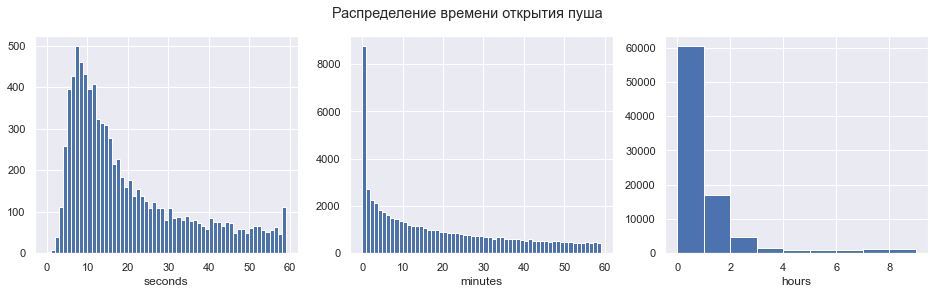

In [13]:
plot_duration_dist(train)

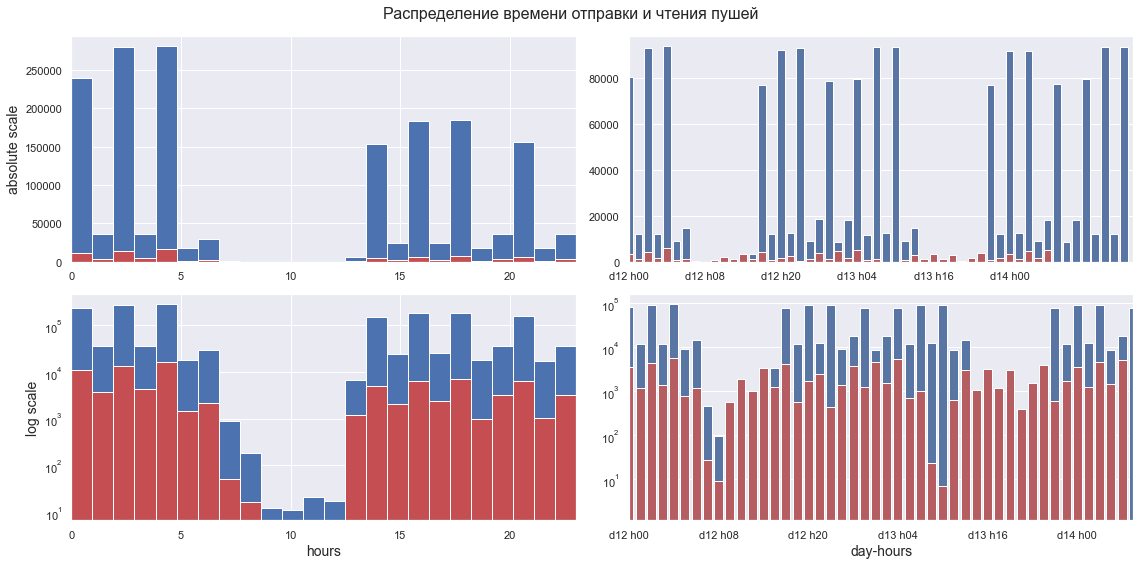

In [14]:
plot_push_time_dist(train)

# Метрика качества

***Для каждого пользователя нам важно только одно время отправки пуша. Поэтому не будем использовать метрики ранжирования.
<br>Будем считать лучшим временем отправки пуша тот момент, когда клиент его открыл. Но исходя из данных: 90% всех открытых пушей были открыты в течение 3х часов после отправки пуша. Поэтому время отправки пуша за 1-3 часа до времени его открытия не также плохо, как время отправки пуша более чем за 3 часа до времени его открытия.***

In [15]:
from scipy import stats

opened = train[train["push_opened"]==1]
mins = (opened["push_opened_time"] - opened["push_time"]).dt.seconds / 60
q1 = stats.percentileofscore(mins, 60) / 100
q2 = stats.percentileofscore(mins, 120) / 100
q3 = stats.percentileofscore(mins, 180) / 100
f"{q1:.2%}, {q2:.2%}, {q3:.2%}"

'65.82%, 84.30%, 89.36%'

Генерируем матрицы взаимодействия пользователя с пушами по часам. Сейчас она будет использоваться для отображения метрик качества.

In [16]:
from functions import get_metrics_matrix
result, origin = get_metrics_matrix(train, test, True, True)

Каждое открытие пуша = 1, каждое НЕоткрытие = -1. Для каждой пары пользователь-час суммируются взаимодействия вззаимодействия пользователя с пушами. Если пользователь не взаимодействовал с пушами или в течение одного часа было одинаковое кол-во открытых и неоткрытых пушей, то значение взаимоджействия = 0. Итого получается матрица:

In [17]:
origin.head(3)

push_hour,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
user_id,,,,,,,,,,,,,,,,,,,,,,,,
0002KP2,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0006KBA,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000LPHR,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0


***Отобразим графически, как будет рассчитываться метрика качества на примере нескольких пользователей на тестовой выборке***
<br>***Для каждого пользователя отображаются два графике:***
- врхний (ORIGIN) - реальное распределение взаимодействие пользователя с пушами по часам на тестовом датасете
- нижний (RESULT) - метрика качества пользователя на тестовом датасете

In [18]:
from functions import plot_metrics_user

***Например пользователь ZZZNR9R открыл пуш в 18 часов. Поэтому метрика качества имеет максимальное значение для 18го часа. Но также не нулевое значение метрики качества будет до времени открытия пуша (часы 17, 16, 15), которое формируется исходя из распределения времени открытия пуша с момента его отпраывки. Также ненулевое значение метрики качества 1 час после времени открытия (19 час), как погрешность определения часа (начало часа, конец и т.п.). Сумма метрики за часы 15, 16, 17 и 19 равна 1.***

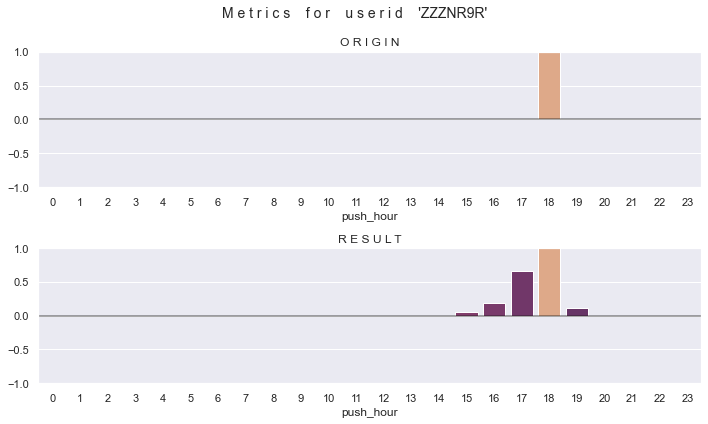

In [19]:
plot_metrics_user("ZZZNR9R", origin, result)

***Пользователь ZXRJ613 три раза открыл пуш за период тестового датасета. Из второго графика видно, что лучшим временем отправки пуша для этого пользователя булет 17 часов.***

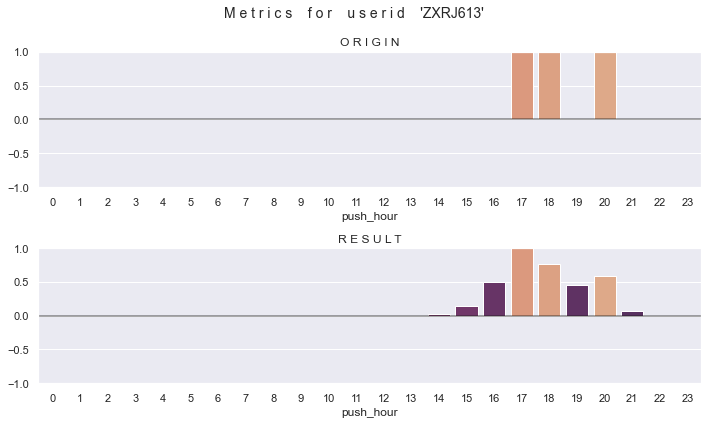

In [20]:
plot_metrics_user("ZXRJ613", origin, result)

***Из взаимодействия пользователя 00DE154 видно, как рассчяитывается метрика качесва в случае НЕоткрытия пуша. А именно, в этом случае распространение сглаженно метрики на 3 часа до время открытия пуша прекращается.***

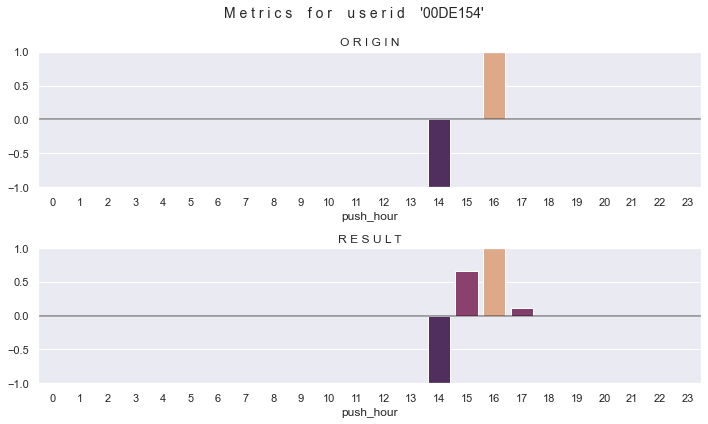

In [21]:
plot_metrics_user("00DE154", origin, result)

***Если пользователь открыл несколько пушей в течение часа (напрмиер пользователь QXR0XKF), то итоговое значение всех положительных метрик пользователя будет нормированно, чтобы наибольшее значение было 1. Это позволяет измбежать предвзятого отношения метрики к пользователям, которые часто взаимодействовали с контентом на периоде тестовой выборки.***

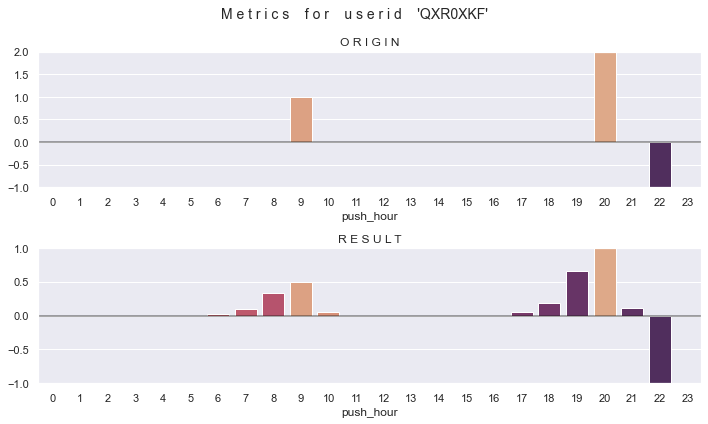

In [22]:
plot_metrics_user("QXR0XKF", origin, result)

***Итоговая метрика качества модели на всей тестовой выборке будет рассчитываться как среднее значение ненулевых метрик по всем клиентам. Исключение нулевых значений метрик позволяет не учитывать случаи, когда рекомендованное моделью время значительно отличается от существующих времен пушей на тестовой выборке.***
<br>В этой метрике есть свои + и -. Буду рад ответить на вопросы касательно этой метрики, если что-то осталось неясным:)

# Модель

In [23]:
users_test = test[["user_id"]].drop_duplicates()

## Baseline

Из анализа выше следует:
<br>1) Больше 65% открытых пушей открыты в течение часа
<br>2) Распределение часов открытия пушей коррелирует с распределением часов отправления пушей (без лагов)
<br>Поэтому предлагаю в качестве бенчмарка использовать следующий подход:
<br>Лучшим часом для отправки пуша считаем час с наибольшей доелй открытых пушей.
<br>*Внимание: уданного подхода может быть смещение из-за неравномерного распределения отправленных пушей*

In [24]:
from model import BaselineModel
baseline = BaselineModel()
baseline.fit(train)
baseline_preds = baseline.predict(users_test)
baseline_preds["best_push_hour"].value_counts().head(3)

13    378174
Name: best_push_hour, dtype: int64

## Simple

Тоже простой подход, но уже с учетом положительных откликов клиента:
- Если у клиента не было положительных откилков или этого клиента не было в тренировочной выборке, то лучшим временем считаем час с наибольшей долей открытых пушей (по аналогии с предыдущим подходом - 13ч.)
- Если у клиента были положительные отклики, то лучшим временем считам час с наибольшим количеством открытых пушей для этого клиента (если таких часов несколько, то берем наименьший из них для простоты). (Важно: в этом случае уже используем время открытия пуша, а не время его отправки)

In [25]:
from model import SimpleModel
simple = SimpleModel()
simple.fit(train)
simple_preds = simple.predict(users_test)
simple_preds["best_push_hour"].value_counts().head(3)

13    353385
2       3252
4       2733
Name: best_push_hour, dtype: int64

## Colaborative Filtering

Используем explicit подход к колаборативной фильтрации. Будем считать, что клиенту подходит час, если в совокупности в этом часу у клиента больше открытых пушей чем неоткрытых. И наоборот. 
<br>Для пользователей, которые не присутствовали на тренировочной выборке будем отправлять моду лучшего времени по результату коллаборативной фильтрации.
<br>Параметры модели подбирать не будем. Иначе это бы производилось на кроссвалидации.

In [26]:
from model import ExplicitCF
explicit = ExplicitCF()
explicit.fit(train)
explicit_preds = explicit.predict(users_test)
explicit_preds["best_push_hour"].value_counts().head(3)

13    203048
5      35773
22     30619
Name: best_push_hour, dtype: int64

# Сравнение качества моделей

Все модели обучаются на тренировочной выборке и проверяются на отложенной тестовой выборке

In [27]:
from functions import calc_metrics

In [28]:
metrics_matrix = get_metrics_matrix(train, test, True)

In [29]:
baseline_metric = calc_metrics(metrics_matrix, baseline_preds)
simple_metric = calc_metrics(metrics_matrix, simple_preds)
explicit_metric = calc_metrics(metrics_matrix, explicit_preds)

In [30]:
res = f"""
Metrics:\thigher->better
Baseline:\t{baseline_metric.mean():.4f}
Simple:\t\t{simple_metric.mean():.4f}
ExplicitCF:\t{explicit_metric.mean():.4f}
"""
print(res)


Metrics:	higher->better
Baseline:	-0.0013
Simple:		-0.0028
ExplicitCF:	-0.0006



Из результирующих метрик по трем моделям видно:
- все три модели имею отрицательно значение метрики, что может свидетельтсвовать о том, что в среднем клиенты не открывают пуш
- модель Simple имеет наихудшее значение метрики (даже хуже бейзлайна) => то есть простой поиск часа с наибольшей долей открытых пушей по всем клиентам работает лучше, чем этот же подход персонализированный по клиентам
- explicite CF показал лучший результат
<br>
<br>Вот, собственно...
<br>Результаты получены на тестовой выборке без подбора параметров на кроссвалидации.
<br>Все модели разработаны в тренировочных целях. 

# Дальнейшие идеи

- Использование бОльшего кол-ва данных о взаимодействиях клиентов с пушами позволит использовать модели ранжирования, т.к. будет больше информации о предпочтениях клиентов.
- Использование дополнительной информации о клиентах и контенте позволит использовать более сложные модели, например комбинированную фильтрацию (content + colaborative based).
- В связи с отсутствием данных по взаимодействию клиентов с пушами в каждый час, можно обучать скоринговую модель, которая будет прогнозировать вероятность того, что в предложенный час клиент откроет пуш. Для такой модели нужно будет определить необходимый для отправки пуша порог вероятности. Таким образом можно будет эффективно использовать всю тестовую выборку.
- др.

# Черновик